3it [00:00, 17.02it/s]                       


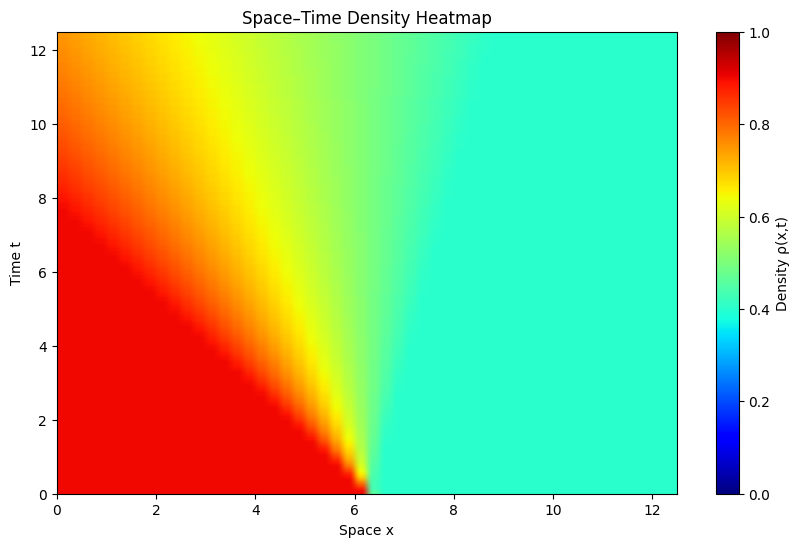

In [22]:
import numpy as np
import torch
from nfv.flows import Greenshield
from nfv.problem import Problem
from nfv.solvers import LaxHopf
from operator_data_pipeline import GridDataset, PiecewiseRandom, preprocess_grids
from torch.utils.data import DataLoader

from numerical_methods.plotter import plot_grid_density

nx = 50
nt = 250
dx = 0.25
dt = 0.05
max_steps = 3
ics = [PiecewiseRandom(ks=[0.9, 0.4], x_noise=False) for _ in range(10)]
problem = Problem(nx=nx, nt=nt, dx=dx, dt=dt, ic=ics, flow=Greenshield())
grids = problem.solve(LaxHopf, batch_size=4, dtype=torch.float64, progressbar=True).cpu().numpy()
plot_grid_density(grids[0], nx, nt, dx, dt)
dataset = GridDataset(preprocess_grids(grids, nx, nt, dx, dt))
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)


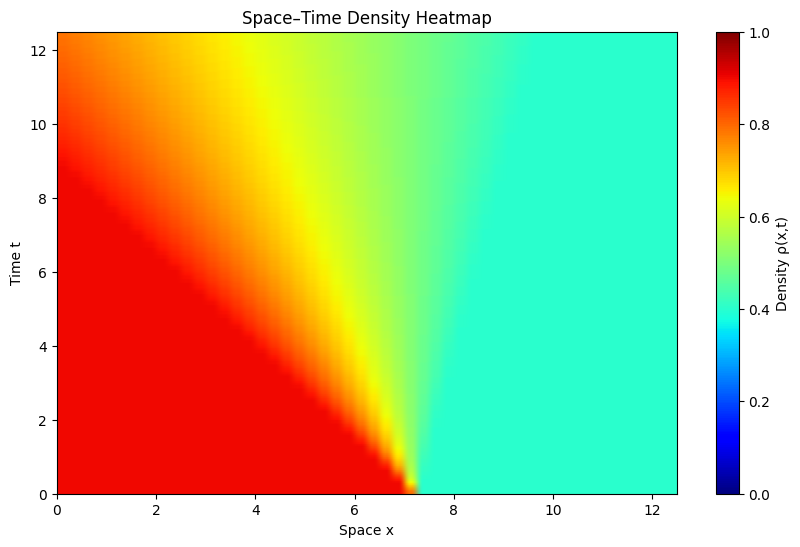

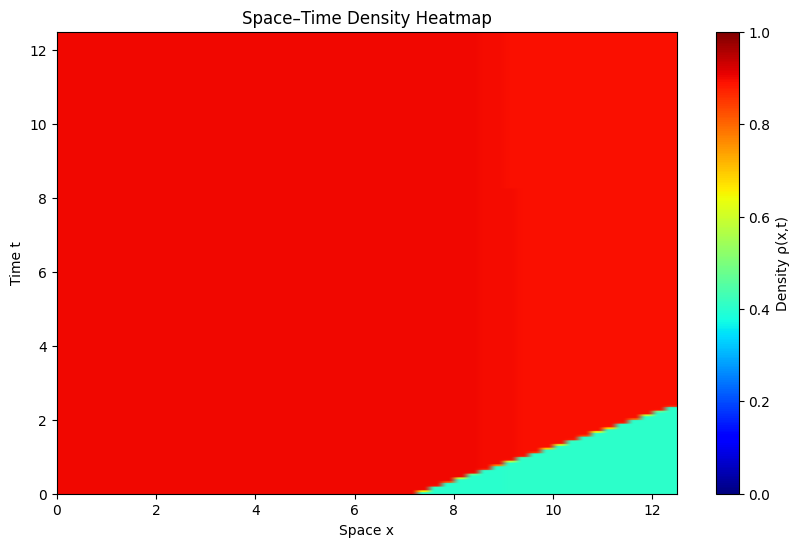

In [23]:
from model import OperatorModel, WaveFront

idx = 1
model = OperatorModel(WaveFront,
    n_modes=(16, 8),
    hidden_dim=32,
    in_channels=3,
    out_channels=1,
    n_layers=4,
    front_threshold=0.5,
)
for grid, target in dataloader:
    pass

# Load state dict and filter out neuralop metadata key
state_dict = torch.load('operator.pth', weights_only=False)
state_dict = {k: v for k, v in state_dict.items() if k != '_metadata'}
model.load_state_dict(state_dict)
pred = model(grid)
plot_grid_density(target[idx].squeeze().detach().cpu().numpy(), nx, nt, dx, dt)
plot_grid_density(pred[idx].squeeze().detach().cpu().numpy(), nx, nt, dx, dt)

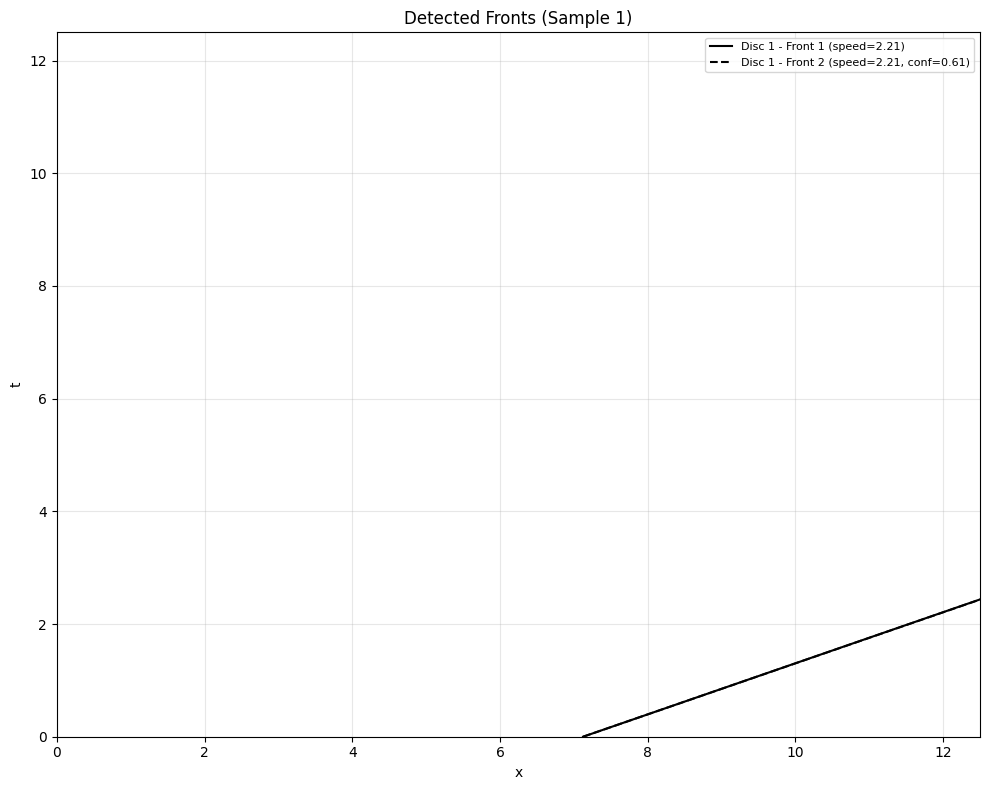

In [24]:
import matplotlib.pyplot as plt

# Get front parameters from the model
with torch.no_grad():
    ic = grid[:, :, 0, :]  # (B, C, X) - initial condition
    front_params, front_count = model.model.front_detector(ic)

# Extract front info for sample idx
front1_speed = front_params[idx, 0, :].cpu().numpy()  # (K,)
front2_speed = front_params[idx, 1, :].cpu().numpy()  # (K,)
front2_conf = front_params[idx, 2, :].cpu().numpy()   # (K,)
front_coords = front_params[idx, 5, :].cpu().numpy()  # (K,)

# Create time array
t_vals = np.linspace(0, nt * dt, nt)

# Plot fronts
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
ax.set_facecolor('white')

# Plot each valid front (confidence > -0.5)
for k in range(front_params.shape[2]):
    if front2_conf[k] > -0.5:  # Valid front
        x0 = front_coords[k]
        conf = front2_conf[k]
        
        # Front 1 trajectory (always present for valid fronts)
        x1_trajectory = x0 + front1_speed[k] * t_vals
        ax.plot(x1_trajectory, t_vals, 'k-', linewidth=1.5, 
                label=f'Disc {k+1} - Front 1 (speed={front1_speed[k]:.2f})')
        
        # Front 2 trajectory (always plot, but show confidence)
        x2_trajectory = x0 + front2_speed[k] * t_vals
        ax.plot(x2_trajectory, t_vals, 'k--', linewidth=1.5,
                label=f'Disc {k+1} - Front 2 (speed={front2_speed[k]:.2f}, conf={conf:.2f})')

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_xlim(0, nx * dx)
ax.set_ylim(0, nt * dt)
ax.set_title(f'Detected Fronts (Sample {idx})')
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()